In [1]:
from google.colab import drive
drive.mount('/content/drive')

root_dir = '/content/drive/My Drive/'

%cd "{root_dir}"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
/content/drive/My Drive


In [2]:
!git clone https://github.com/xelav/Insider-Threat-CERT /root/repo

import sys
sys.path.append("/root/repo")

Cloning into '/root/repo'...
remote: Enumerating objects: 99, done.
remote: Counting objects: 100% (99/99), done.
remote: Compressing objects: 100% (51/51), done.
remote: Total 99 (delta 61), reused 81 (delta 46), pack-reused 0
Unpacking objects: 100% (99/99), done.


In [0]:
from pathlib import Path
import pandas as pd
import pickle
import numpy as np
import shutil
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
from torch.nn import functional as F

from src.models import InsiderClassifier, LSTM_Encoder
from src.params import get_params
from src.dataset import CertDataset, create_data_loaders


In [0]:
output_dir = Path(f'{root_dir}/Datasets/CERT_output')
answers_dir = Path(f'{root_dir}/Datasets/CERT/answers')
main_answers_file = answers_dir / "insiders.csv"

# Подготовка LSTM-векторов

In [0]:
lstm_checkpoint = output_dir / 'checkpoints/lstm/final2-nll/final_model_3040.pth'
assert(lstm_checkpoint.is_file())

In [0]:
actions, targets = CertDataset.prepare_dataset(output_dir / 'aggregated.pkl', main_answers_file, min_length=50, max_length=200)

In [0]:
device = 'cuda'
batch = 256

cert_dataset = CertDataset(actions, targets)
train_loader, val_loader = create_data_loaders(cert_dataset, validation_split=0.3, random_seed=0, batch_size=batch)

params = get_params()

In [0]:
lstm_encoder = LSTM_Encoder(params['model']['lstm_encoder'])

device = 'cuda'

lstm_encoder.requires_grad = False
lstm_encoder.eval()
lstm_encoder.load_state_dict(
    torch.load(lstm_checkpoint, map_location=torch.device(device)), strict=True
)

<All keys matched successfully>

In [0]:
def prepare_batch(batch, device=None, non_blocking=None, num_classes=64, train=True):

    actions = batch['actions']

    actions = actions.to(device).to(torch.int64)
    actions = F.one_hot(actions, num_classes=64).float()
    
    return actions, batch['targets']

In [0]:
def prepare_encoded_dataset(loader, model_encoder):
    
    all_targets = None
    vecs = None

    for batch in tqdm(loader):
        actions, targets = prepare_batch(batch)

        result = model_encoder(actions)
        result = result.detach().cpu().numpy()
        targets = targets.detach().cpu().numpy()

        if all_targets is not None:
            all_targets = np.concatenate([all_targets, targets], axis=0)
        else:
            all_targets = targets

        if vecs is not None:
            vecs = np.concatenate([vecs, result], axis=0)
        else:
            vecs = result
    
    return vecs, all_targets

In [0]:
val_vecs, val_targets = prepare_encoded_dataset(val_loader, lstm_encoder)
val_vecs.shape, val_targets.shape

100%|██████████| 130/130 [01:16<00:00,  1.70it/s]


((33276, 200, 40), (33276,))

In [0]:
train_vecs, train_targets = prepare_encoded_dataset(train_loader, lstm_encoder)
train_vecs.shape, train_targets.shape

100%|██████████| 304/304 [04:05<00:00,  1.24it/s]


((77644, 200, 40), (77644,))

In [0]:
train_vecs.shape, val_vecs.shape, train_targets.shape, val_targets.shape

((77644, 200, 40), (33276, 200, 40), (77644,), (33276,))

In [0]:
np.save(lstm_checkpoint.parent / 'train_vecs.npy', train_vecs)
np.save(lstm_checkpoint.parent / 'val_vecs.npy', val_vecs)

np.save(lstm_checkpoint.parent / 'train_targets.npy', train_targets)
np.save(lstm_checkpoint.parent / 'val_targets.npy', val_targets)

# Тестируем классификаторы

In [6]:
train_vecs = np.load(lstm_checkpoint.parent / 'train_vecs.npy')
val_vecs = np.load(lstm_checkpoint.parent / 'val_vecs.npy')

train_targets = np.load(lstm_checkpoint.parent / 'train_targets.npy')
val_targets = np.load(lstm_checkpoint.parent / 'val_targets.npy')

train_vecs = train_vecs.reshape(train_vecs.shape[0], -1)
val_vecs = val_vecs.reshape(val_vecs.shape[0], -1)

train_vecs.shape, val_vecs.shape, train_targets.shape, val_targets.shape

((77644, 200, 40), (33276, 200, 40), (77644,), (33276,))

In [0]:
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.decomposition import PCA, NMF, TruncatedSVD
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline

## Logistic Regresssion

In [0]:
linear_model = SGDClassifier(verbose=1, loss='modified_huber', max_iter=100)

In [0]:
linear_model.fit(train_vecs, train_targets)

In [0]:
linear_model.predict_proba(val_vecs).sum()

33276.0

In [0]:
probs = linear_model.predict_proba(val_vecs)[:,1]

In [0]:
roc_auc_score(val_targets, probs)

0.49960789045062437

In [0]:
linear_model = LogisticRegression(verbose=1, max_iter=500)
linear_model.fit(train_vecs, train_targets)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  4.1min finished


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=500,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=1,
                   warm_start=False)

In [0]:
train_probs = linear_model.predict_proba(train_vecs)[:,1]
f'train ROC AUC: {roc_auc_score(train_targets, train_probs)}'

'train ROC AUC: 0.6871981942065118'

In [0]:
probs = linear_model.predict_proba(val_vecs)[:,1]
f'val ROC AUC: {roc_auc_score(val_targets, probs)}'

'val ROC AUC: 0.35078624639906963'

In [0]:
probs.mean()

0.004161924859565712

In [0]:
train_probs.mean()

0.0040941781466248325

## SVM

TODO: сделать уменьшение размерности или ансамблирование

In [0]:
def checl_model(model, divide_dataset_size_by=1, shift=0, **model_kwargs):
    model.fit(train_vecs[shift::divide_dataset_size_by], train_targets[shift::divide_dataset_size_by])
    print('fitted!')
    train_probs = model.predict_proba(train_vecs)[:,1]
    print(f'train ROC AUC: {roc_auc_score(train_targets, train_probs)}')
    probs = model.predict_proba(val_vecs)[:,1]
    print(f'val ROC AUC: {roc_auc_score(val_targets, probs)}')

In [13]:
svm_model = SVC(kernel='linear', verbose=1, probability=True)
checl_model(svm_model, divide_dataset_size_by=10)

[LibSVM]fitted!
train ROC AUC: 0.5521633332393683
val ROC AUC: 0.1491868053406013


In [14]:
svm_model = SVC(kernel='poly', verbose=1, degree=3, probability=True)
checl_model(svm_model, divide_dataset_size_by=10)

[LibSVM]fitted!
train ROC AUC: 0.5476269424708271
val ROC AUC: 0.19303978354366164


In [15]:
svm_model = SVC(kernel='rbf', verbose=1, probability=True)
checl_model(svm_model, divide_dataset_size_by=10)

[LibSVM]fitted!
train ROC AUC: 0.5307831557563787
val ROC AUC: 0.20794983568978154


In [16]:
svm_model = SVC(kernel='sigmoid', verbose=1, probability=True)
checl_model(svm_model, divide_dataset_size_by=10)

[LibSVM]fitted!
train ROC AUC: 0.5325750870193234
val ROC AUC: 0.21466811115934875


# Decomposition

## PCA

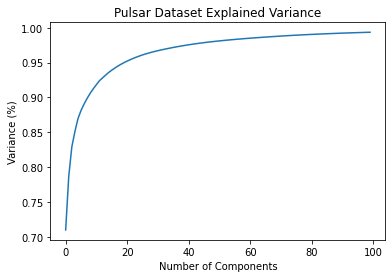

0.993649


In [22]:
pca_model = PCA(n_components=100)

pca_model.fit(train_vecs)

plt.figure()
plt.plot(np.cumsum(pca_model.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('Pulsar Dataset Explained Variance')
plt.show()
print(f'{np.cumsum(pca_model.explained_variance_ratio_)[-1]:.6f}')

In [0]:
train_vecs_pca = pca_model.transform(train_vecs)
val_vecs_pca = pca_model.transform(val_vecs)

In [0]:
def check_model_pca(model, divide_dataset_size_by=1, shift=0, **model_kwargs):
    model.fit(train_vecs_pca[shift::divide_dataset_size_by], train_targets[shift::divide_dataset_size_by])
    print('fitted!')
    train_probs = model.predict_proba(train_vecs_pca)[:,1]
    print(f'train ROC AUC: {roc_auc_score(train_targets, train_probs)}')
    probs = model.predict_proba(val_vecs_pca)[:,1]
    print(f'val ROC AUC: {roc_auc_score(val_targets, probs)}')

In [32]:
svm_model = SVC(kernel='linear', verbose=1, probability=True)
check_model_pca(svm_model, divide_dataset_size_by=2)

[LibSVM]fitted!
train ROC AUC: 0.49972683502022364
val ROC AUC: 0.6053563252264396


In [33]:
svm_model = SVC(kernel='poly', verbose=1, degree=3, probability=True)
check_model_pca(svm_model, divide_dataset_size_by=2)

[LibSVM]fitted!
train ROC AUC: 0.5922033386912453
val ROC AUC: 0.16184259842543047


In [34]:
svm_model = SVC(kernel='rbf', verbose=1, probability=True)
check_model_pca(svm_model, divide_dataset_size_by=2)

[LibSVM]fitted!
train ROC AUC: 0.6149832011288534
val ROC AUC: 0.1398157332349681


In [0]:
svm_model = SVC(kernel='sigmoid', verbose=1, probability=True)
check_model_pca(svm_model, divide_dataset_size_by=2)

[LibSVM]fitted!


## NMF

In [0]:
class UniformScaler(TransformerMixin):
    def __init__(self, min=-1, scale=2, *featurizers):
        self.min = min
        self.scale = scale

    def fit(self, X, y=None):
        return self

   def transform(self, X):
        return (X - self.min) / self.scale

In [0]:
nmf_model = Pipeline([
          ('scaler', UniformScaler()),
          ('nmf', NMF(n_components=100))
          ])
nmf_model.fit(train_vecs)

In [0]:
train_vecs_nmf = nmf_model.transform(train_vecs)
val_vecs_nmf = nmf_model.transform(val_vecs)

In [0]:
def check_model_nmf(model, divide_dataset_size_by=1, shift=0, **model_kwargs):
    model.fit(train_vecs_nmf[shift::divide_dataset_size_by], train_targets[shift::divide_dataset_size_by])
    print('fitted!')
    train_probs = model.predict_proba(train_vecs_nmf)[:,1]
    print(f'train ROC AUC: {roc_auc_score(train_targets, train_probs)}')
    probs = model.predict_proba(val_vecs_nmf)[:,1]
    print(f'val ROC AUC: {roc_auc_score(val_targets, probs)}')

In [0]:
svm_model = SVC(kernel='linear', verbose=1, probability=True)
check_model_nmf(svm_model, divide_dataset_size_by=4)

[LibSVM]

In [0]:
svm_model = SVC(kernel='poly', verbose=1, degree=3, probability=True)
check_model_nmf(svm_model, divide_dataset_size_by=4)

In [0]:
svm_model = SVC(kernel='rbf', verbose=1, probability=True)
check_model_nmf(svm_model, divide_dataset_size_by=4)

In [0]:
svm_model = SVC(kernel='sigmoid', verbose=1, probability=True)
check_model_nmf(svm_model, divide_dataset_size_by=4)

# Random Forest

In [0]:
rfc_model = RandomForestClassifier(verbose=1)
check_model_nmf(rfc_model)